In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import math
import itertools
from collections import defaultdict
from operator import itemgetter

import torch
import pandas as pd
# import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import normalize
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

from phoneme_lm import PhonemeLM, build_data_loader, build_vocab, encode_pronunciation
from utils import load_data, split_data

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Training the Model ##

In [4]:
df = load_data(True)
len(df)

124996

In [5]:
phoneme_to_idx, idx_to_phoneme = build_vocab(df.pronunciation.values)
df['phoneme_ids'] = df.pronunciation.apply(lambda pronunciation: encode_pronunciation(pronunciation, phoneme_to_idx))

In [6]:
df['pronunciation_string'] = df.pronunciation.apply(' '.join)
df['length'] = df.pronunciation.apply(len)

In [7]:
train_df, dev_df, test_df = split_data(df, dev_proportion=.2, test_proportion=.01)

In [8]:
len(train_df), len(dev_df), len(test_df)

(98746, 25000, 1250)

In [9]:
# 63 minutes for 16 models. 4 minutes each

In [17]:
%%time

param_grid = ParameterGrid({
    'rnn_type': ['gru'],
    'embedding_dimension': [10, 50, 100, 200],
    'rnn_hidden_dimension': [50, 100, 200, 400],
})

records = []
for params in tqdm(param_grid):
    lm = PhonemeLM(phoneme_to_idx, device='cuda', batch_size=1024,  max_epochs=200, **params)
    print('Model Params:', params)
    train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=10)
    for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
        record = params.copy()
        record['epoch'] = epoch
        record['train_loss'] = train_loss
        record['dev_loss'] = dev_loss
    
        records.append(record)

models_df = pd.DataFrame.from_records(records)

Model Params: {'embedding_dimension': 10, 'rnn_hidden_dimension': 50, 'rnn_type': 'gru'}
Epoch 1: train loss: 0.9762ss: 0.9723	assess loss: 1.4814
	 OW0 G AH2 L L B <PAD> AE0 <PAD> <PAD>
	 
	 
	 AA2 AH0 F F
	 EY1 N TH R ER0 ZH S ER0 <PAD> <PAD>
Epoch 2: train loss: 0.8071ss: 0.8143	assess loss: 1.2437
	 AH0 AA1 CH R
	 EH2 L OW2
	 N ER0 G M AW1 AE1
	 ZH
	 <PAD> AA1 T AW2 EY1 <PAD> <PAD> <PAD> <PAD> <PAD>
Epoch 3: train loss: 0.7514ss: 0.7348	assess loss: 1.1612
	 AW0 N IH0 EH1 R IH0 AH0 Z N
	 T AO2 K
	 UW0 AO1 NG
	 Z AH2 T ER0 P N ER0
	 D F AA2
Epoch 4: train loss: 0.7202ss: 0.7020	assess loss: 1.1147
	 ER0 F N AH0 N
	 EH1 Z ER0 IY0 N <PAD> <PAD> <PAD> <PAD> <PAD>
	 Z IH0
	 N T
	 L D R AE1 AH0 M T
Epoch 5: train loss: 0.6971ss: 0.6734	assess loss: 1.0781
	 EY0 Z P AH0 L AA1 R S IY0
	 EH2 B EY1 N N
	 L TH T
	 HH ER0 S AH0 IH0 AH0 N D
	 EH0 L Z AH0 N K
Epoch 6: train loss: 0.6738ss: 0.6807	assess loss: 1.0429
	 SH AO1 K IH1 T
	 AA1 V AE2 AH0 L Z
	 D
	 V M G K T M B Z
	 <PAD> L <PAD> <PAD>

Epoch 55: train loss: 0.5323ss: 0.5357	assess loss: 0.8278
	 AE1 S T S AH0 N
	 AH0 N EH1 L
	 EY1 L AH0 M
	 AA0 R UW1 EH1 K IH0 T EH2 R
	 ER1 T ER0
Epoch 56: train loss: 0.5318ss: 0.5300	assess loss: 0.8269
	 AA2 D IY0 AA1 R AH0
	 AH1 K S AH0 N
	 M EY1 G AH0
	 IH0 G Z UW1 N IY0 AH0 N
	 IH1 G Z IY0 L IY0
Epoch 57: train loss: 0.5314ss: 0.5488	assess loss: 0.8262
	 L EY1 N M EY2 K
	 AE1 DH ER0
	 ER1 TH Z
	 W IH1 L AE0 K
	 L AH1 K S
Epoch 58: train loss: 0.5310ss: 0.5321	assess loss: 0.8263
	 AA1 R B IH0 NG
	 AE1 N
	 AO2 R T OW1 N OW0
	 R EH1 S IH0 D
	 R OW1 N AA0 K
Epoch 59: train loss: 0.5306ss: 0.5325	assess loss: 0.8257
	 AA0 R V IY1 N EY0
	 EH1 D AH0 L B IH0 K
	 R IH2 G AH0 N IH1 Z AH0 T ER0
	 AH1 CH L AH0 M
	 AA1 R IH2 P IY0
Epoch 60: train loss: 0.5303ss: 0.5429	assess loss: 0.8249
	 AE1 P IH0 N T S
	 EY1 SH IY1
	 AE1 NG K S T ER0 D
	 AH0 M P R IY1 N IH0 NG Z
	 R AW1 JH ER0 Z
Epoch 61: train loss: 0.5299ss: 0.5194	assess loss: 0.8247
	 AE1 P ER0
	 EH1 L IH0 NG
	 AA1 L AH0 T
	 AE1 T 

Epoch 111: train loss: 0.5210ss: 0.5132	assess loss: 0.8126
	 R IY1 T
	 R EH1 CH AH0
	 EH0 D R AA1 TH
	 IH2 S IH0 N T AA1 R
	 AE2 S AA0 N AA1
Epoch 112: train loss: 0.5208ss: 0.5198	assess loss: 0.8121
	 AH0 L UW1 SH AH0 S
	 IY1 N T
	 AH1 T IH0 L Z
	 AH1 S AH0 K AH0
	 OW1 L K ER0
Epoch 113: train loss: 0.5208ss: 0.5292	assess loss: 0.8124
	 IY0 M AA0 N AA1 R OW0
	 AA1 R S AH0 N
	 L IY1 P
	 AE1 N D
	 R AA1 M P
Epoch 114: train loss: 0.5208ss: 0.5225	assess loss: 0.8128
	 IH1 DH ER0 HH AE0 M B
	 IY1 Z IH0 Z
	 T R EY1 B N AY2 ER0
	 K AA1 M ER0 N IH0 NG
	 IY1 Z AH0 N
Epoch 115: train loss: 0.5206ss: 0.5234	assess loss: 0.8121
	 OW1 M
	 Y UW1 Z D AW2 M
	 AH0 N S EH1 T IH0 K L IY0 JH
	 R EY1 D AH0
	 AE1 M Z
Epoch 116: train loss: 0.5205ss: 0.5084	assess loss: 0.8122
	 AO1 F AH0
	 AE1 R IH0 NG
	 L IH1 T ER0 D
	 AH0 M AY1 N S AH0 N T IH0 D
	 AE1 L TH R IH0 K
Epoch 117: train loss: 0.5204ss: 0.5200	assess loss: 0.8116
	 AH0 V EH1 K SH AH0 N
	 AA1 P L AH0 V EH1 N D
	 AA2 M AH0 CH IY0 L IY1 N S
	

Epoch 167: train loss: 0.5173ss: 0.5150	assess loss: 0.8081
	 UW0 S AE1 N T IY0 AH0
	 L EH1 S M AH0 N
	 AA1 R P ER0
	 AE1 R IY0 Z
	 AH1 M
Epoch 168: train loss: 0.5174ss: 0.5167	assess loss: 0.8079
	 OW0 T OW1 N OW0
	 IY1 CH
	 OW1 JH
	 OW1 N AH0 M
	 EY1 AA1 L
Epoch 169: train loss: 0.5173ss: 0.5217	assess loss: 0.8078
	 L AA1 R G EY0 P L IH0 NG
	 ER1 G IH0 N AH0 L
	 IY0 L AA1 N OW0
	 W IY1 M Z
	 ER1 JH IH0 W EY2 K
Epoch 170: train loss: 0.5172ss: 0.5271	assess loss: 0.8081
	 UW0 M IY1 L OW0
	 AH1 N CH ER0 S EH1 N T IH0 D
	 EH1 M P K AH2 SH AH0
	 AA2 R D IH0 M AE1 G ER0 AO0 R
	 AA0 L F EH1 R OW0
Epoch 171: train loss: 0.5172ss: 0.5340	assess loss: 0.8076
	 R IY1 D AH0 N
	 R IH1 SH AH0 N
	 IY1 R AH0 N Z
	 AH0 M IH1 L AH0 D ER0
	 AH0 N D R EH1 R IY0 AH0 N T
Epoch 172: train loss: 0.5171ss: 0.5148	assess loss: 0.8076
	 Y UW1 CH EH0 K
	 AY1 N IH2 S T
	 OW0 P UW1 M AH0
	 AH1 F ER0 D
	 L AY1 D
Epoch 173: train loss: 0.5172ss: 0.5152	assess loss: 0.8080
	 L ER0 AE1 N S AH0
	 IH1 L ER0 Z
	 AA1 

Epoch 21: train loss: 0.5483ss: 0.5461	assess loss: 0.8500
	 AE1 Z AH0 N L AA2 P L ER0
	 EH2 N S K AH0 N EH1 N T B
	 AA1 R IH0 K
	 IH1 N AH0 S T
	 R AE1 S T S
Epoch 22: train loss: 0.5464ss: 0.5517	assess loss: 0.8474
	 IY1 D Z ER0
	 AH0 M EH1 N S UW2 Z
	 IH1 S K ER0
	 AA0 L OW1 IH0 JH
	 ER1 M L
Epoch 23: train loss: 0.5447ss: 0.5389	assess loss: 0.8452
	 OW1 V OW0 N S
	 AA1 R B AH0 L
	 AA1 R G L AH0 L IY2 Z AH0 N
	 R AH1 F
	 AH0 N AE1 Z AH0 D
Epoch 24: train loss: 0.5429ss: 0.5458	assess loss: 0.8426
	 AH2 N IH0 T R AH0 F Y UW1 D
	 AA1 R B EY2 T S
	 AE1 N N ER0
	 AE1 D IH0 NG
	 L AA1 M AH0 L AH0
Epoch 25: train loss: 0.5413ss: 0.5491	assess loss: 0.8398
	 HH AY1 N IH0 K L AY2 CH Z
	 AE1 CH UW0 T
	 R OW1 F AH0 L Z
	 AA1 R AH0 K L IH0 NG
	 AH0 D EH1 T ER0
Epoch 26: train loss: 0.5397ss: 0.5479	assess loss: 0.8377
	 L IH0 N AA0 N IY1 CH AW0
	 ER1 P R AH0
	 AA0 L AA0 L IH1 S T AH0 B AH0
	 AA1 N S IH0 S
	 AE1 N HH AW2
Epoch 27: train loss: 0.5383ss: 0.5409	assess loss: 0.8357
	 AH1 S K AH0

Epoch 76: train loss: 0.5072ss: 0.5171	assess loss: 0.7971
	 AE1 S T ER0 M AO2 R L ER0
	 AA1 N CH ER0 S AH0 N
	 R EH1 K SH AE0 N S
	 IH1 N L IY0
	 AH0 N S ER1 T S
Epoch 77: train loss: 0.5070ss: 0.5025	assess loss: 0.7973
	 N IH1 B R IH0 L EY2 K IH0 NG
	 K IY1 L
	 AW1 N T ER0 P AA2 R T AH0 D
	 AA1 N S AY2 Z IH0 Z
	 AE1 M AH0 N D
Epoch 78: train loss: 0.5065ss: 0.5127	assess loss: 0.7971
	 AH0 N IH1 R N
	 AA0 R IY1 N OW0
	 AA0 NG G Y UW1 Z AH0 N
	 AE1 L AH0 N Z
	 AA0 R D EY1 Z
Epoch 79: train loss: 0.5064ss: 0.5067	assess loss: 0.7969
	 W AY1 N AH0 S T
	 AA1 N AA0 R AA0 Z
	 Y AE1 M B AH0 T ER0 IY0
	 L IH1 S
	 ER1 K Y AH0 P IH2 S T
Epoch 80: train loss: 0.5062ss: 0.5171	assess loss: 0.7970
	 IH1 B AH0 N IH0 T
	 AH1 N IY0
	 AE2 N T AH0 L AH0 T AE1 L Y
	 K AY1 P
	 IY0 AE1 N D IY0 AH0 L
Epoch 81: train loss: 0.5057ss: 0.5057	assess loss: 0.7966
	 K AH1 N T AH0 S
	 T R EY1 CH ER0
	 AY1 D AH0 M ER0 Z
	 AE1 L S T AH0 N
	 T ER1 B AH0 K IH2 SH
Epoch 82: train loss: 0.5057ss: 0.5063	assess loss: 

Epoch 132: train loss: 0.4980ss: 0.4978	assess loss: 0.7911
	 AE1 K JH IH0 N M AE2 N S
	 L AE1 M ER0 IH0 NG L IY0
	 OW1 M P L OW2 M Z
	 AO1 R N ER0
	 ER1 M Z
Epoch 133: train loss: 0.4979ss: 0.4975	assess loss: 0.7913
	 AH0 N F L AE1 K D
	 R IY1 M
	 R IH1 CH ER0 D
	 AO1 R T OW2
	 Y UW1 M ER0 AY2 Z
Epoch 134: train loss: 0.4978ss: 0.4911	assess loss: 0.7913
	 ER1 AH0 K AH0 L
	 T AO1 R IY0
	 AH0 D IY1 N IY0
	 T OW1 CH ER0
	 EH1 N HH AH0 L AH0 S
Epoch 135: train loss: 0.4975ss: 0.4883	assess loss: 0.7910
	 AA0 T L UW0 N OW1 N IY0
	 ER1 AH0 L
	 AO1 R M AO0 R N IH0 S T
	 AA1 S K AW0
	 AA1 R S AH0 N
Epoch 136: train loss: 0.4977ss: 0.5033	assess loss: 0.7912
	 EH1 N S IH0 S IY0
	 AO1 L
	 EH1 M G R OW0
	 IY1 B EH2 R IY0 N AH0 S
	 UW1 B Y IH0 L
Epoch 137: train loss: 0.4976ss: 0.5016	assess loss: 0.7911
	 EY2 S T UW0 B IY1 Z
	 AA0 R AA0 L IY1 N OW0
	 AA0 P IY1 N OW0
	 OW1 T AH0 T AY2 Z
	 L UW1 P
Epoch 138: train loss: 0.4975ss: 0.4900	assess loss: 0.7914
	 EH1 T ER0 IY0
	 AW1 N S EH2 V
	 AA0 S

Epoch 186: train loss: 0.4940ss: 0.4953	assess loss: 0.7905
	 R AH0 M P EH1 Z AH0 T IH0 V
	 AH0 N V AY1 D
	 OW2 M AO0 R EH1 L IY0
	 R IH1 M P T
	 AE1 N JH ER0 W UH2 D
Epoch 187: train loss: 0.4938ss: 0.5010	assess loss: 0.7900
	 W IY1 D F
	 T R UW1 T
	 R AE1 D T
	 T AA1 R B L IY0
	 IH1 CH ER0 AH0 L IY0
Epoch 188: train loss: 0.4938ss: 0.5093	assess loss: 0.7903
	 AE1 D N IY0
	 AE1 M AH0 N IH0 NG
	 L IH1 P F ER0
	 L IY0 HH OY1 Z
	 R AE1 K T
Epoch 189: train loss: 0.4938ss: 0.4938	assess loss: 0.7902
	 R AO1 S
	 UW0 S T EY1 T AH0
	 AE1 G IH2 L IH0 NG
	 AH0 N T OW1 N
	 EH0 T R AA0 V AA1 K IY0
Epoch 190: train loss: 0.4936ss: 0.5056	assess loss: 0.7900
	 EY1 T S
	 R EY1 B AO2 R
	 OW1 L M IH0 N
	 AA1 NG G AH0 L
	 AH0 S P EY1 N D
Epoch 191: train loss: 0.4937ss: 0.4946	assess loss: 0.7905
	 L EH1 ZH K EY2 K
	 L IY1 G AH0 G AO2 M
	 AA1 B IH0 K
	 OW1 S AH0 B IY0 ER0
	 AO1 B
Epoch 192: train loss: 0.4935ss: 0.4885	assess loss: 0.7897
	 K R AA1 P AO2 R
	 EH1 L V ER0
	 UW2 M N IH0 L AE1 N
	 AH0 B

Epoch 41: train loss: 0.5041ss: 0.4968	assess loss: 0.7951
	 R IH1 S T IH0 NG
	 AH1 L CH AH0
	 AA1 P IY0 Z
	 EY1 TH
	 AA1 T AH0 L AH0 N L IY0
Epoch 42: train loss: 0.5033ss: 0.4982	assess loss: 0.7943
	 AE1 M AH0 N Z
	 EH1 R OW0
	 AO1
	 L AE1 K
	 AH0 L G AE1 N T
Epoch 43: train loss: 0.5023ss: 0.4905	assess loss: 0.7940
	 AH1 N T OW2 T
	 AA2 N S AH0 Z EY1 SH AH0 N
	 AA1 N TH EY0 V
	 Y UW0 B IH1 R M AH0 N
	 L IH1 K S
Epoch 44: train loss: 0.5014ss: 0.4975	assess loss: 0.7929
	 EH1 N ER0 V IH0 L
	 EH1 L ER0 Z
	 W IY1 N
	 AH0 F OW1 T ER0
	 AE1 N T AH0 Z AH0 N
Epoch 45: train loss: 0.5003ss: 0.4937	assess loss: 0.7918
	 IY1 L S IY0
	 T OW1 L AH0 N
	 T IY1 CH
	 AH0 K T AY1 M IH0 K
	 AO1 K ER0
Epoch 46: train loss: 0.4992ss: 0.5010	assess loss: 0.7909
	 AH0 L UW1 SH AH0
	 AH0 N S P R EH1 JH T AH0 L
	 AY1 S ER0
	 R IH1 M IY0
	 AA1 R N
Epoch 47: train loss: 0.4985ss: 0.5002	assess loss: 0.7908
	 IH1 M V IH0 B ER0 T
	 AE1 P Y UW2 T ER0 Z
	 IH2 F OW0 Z AA1 L IY0
	 N OW1 K IY0
	 P EH1 R IH0 L
Epo

Epoch 97: train loss: 0.4700ss: 0.4621	assess loss: 0.7816
	 EH1 B ER0 L
	 AE1 N Y AH0 N
	 AA1 M P L AH0 K EY2 T IH0 NG
	 AA2 N T IH0 M P IY1 N AH0 T
	 AH0 N F Y UW1 T ER0 Z
Epoch 98: train loss: 0.4698ss: 0.4718	assess loss: 0.7818
	 OW1 L K
	 AE1 L IH0 F IY0
	 AO1 R G L EY0
	 AA2 L EY0 L EY1 T AH0
	 AA1 P CH ER0 Z ER0
Epoch 99: train loss: 0.4696ss: 0.4678	assess loss: 0.7828
	 EH2 R AH0 L EH1 N SH AH0 N
	 UW1 P R IH0 P T AH0 S
	 R EH1 NG K IY0
	 AA1 S T AH0 L
	 UW1 P ER0
Epoch 100: train loss: 0.4693ss: 0.4764	assess loss: 0.7823
	 AH0 M P L AY1 IH0 NG
	 L OW1 T M AH0 N
	 AA1 P IY0 W EH2 L
	 OW0 HH IY1 N AH0 N
	 R AW1 W EH0 L
Epoch 101: train loss: 0.4689ss: 0.4760	assess loss: 0.7818
	 AA1 T ER0 D
	 R EH1 S K
	 AA0 R AA0 M AA1 R OW0
	 Y AH0 N AO1 F S K IY0
	 AE1 S SH
Epoch 102: train loss: 0.4683ss: 0.4740	assess loss: 0.7819
	 R AH1 K S T AW2 N Z
	 AA0 R T UW1 AH0 L
	 UW1 L UW0 AE2 JH IH0 Z
	 AE1 M IH0 L IY0
	 AA0 M AA0 R AA1 R AH0
Epoch 103: train loss: 0.4681ss: 0.4722	assess lo

Epoch 151: train loss: 0.4574ss: 0.4583	assess loss: 0.7881
	 IH1 L Z
	 T OW1 G IH0 NG
	 IY1 P ER0
	 AH1 M AH0 N
	 K AH1 L P T
Epoch 152: train loss: 0.4572ss: 0.4617	assess loss: 0.7880
	 AE1 K B IY0
	 AH0 N F AY1 N AH0 L IH0 NG
	 AA1 B IY0
	 AE2 N AH0 M EH1 N T AH0
	 AE1 S T IH0 D
Epoch 153: train loss: 0.4571ss: 0.4623	assess loss: 0.7875
	 P IH1 R D
	 P AH1 G AH0 L D
	 AH0 F IH1 SH AH0 N EH2 R IY0
	 EY1 L
	 IH1 P IY0 K AA2 T
Epoch 154: train loss: 0.4566ss: 0.4682	assess loss: 0.7877
	 OW1 B IH2 SH
	 AA0 N Z AH0 L IH1 N AA0 R
	 AA1 K AH0 P AH2 S T ER0
	 AA1 N D IH0 N
	 ER0 OW1 Y AH0
Epoch 155: train loss: 0.4566ss: 0.4498	assess loss: 0.7888
	 OW1 L ER0 Z
	 R UW1 M
	 OW1 G ER0
	 AA1 TH
	 AW1 N T ER0 S UW2 L Z
Epoch 156: train loss: 0.4565ss: 0.4593	assess loss: 0.7883
	 AA1 CH AO2
	 AE2 M IH0 F AE1 L IY0 OW0
	 AA1 N S T AH0 T UW2 T S
	 AA1 T
	 OW0 ER1 S
Epoch 157: train loss: 0.4563ss: 0.4550	assess loss: 0.7880
	 R IY0 AA1 T S K IY0
	 AA1 T IY0 AH0 N
	 AW1 N T ER0 R UW2 T S
	 AA1 

KeyboardInterrupt: 

In [26]:
models_df.embedding_dimension.unique()

array([10])

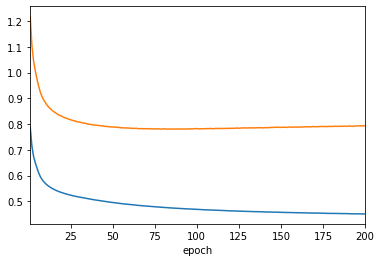

In [29]:
models_df = pd.DataFrame.from_records(records)
models_df.sort_values('dev_loss')
t = models_df[(models_df.embedding_dimension==10) & (models_df.rnn_hidden_dimension==200)]
t.set_index('epoch').train_loss.plot()
t.set_index('epoch').dev_loss.plot()

In [48]:
%%time

param_grid = ParameterGrid({
    'rnn_type': ['gru'],
    'embedding_dimension': [10, 100, 400],
    'rnn_hidden_dimension': [50, 200, 400],
})

records = []
for params in tqdm(param_grid):
    lm = PhonemeLM(phoneme_to_idx, device='cuda', batch_size=1024,  max_epochs=200, **params)
    print('Model Params:', params)
    train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=3)
    for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
        record = params.copy()
        record['epoch'] = epoch
        record['train_loss'] = train_loss
        record['dev_loss'] = dev_loss
    
        records.append(record)

models_df = pd.DataFrame.from_records(records)

Model Params: {'embedding_dimension': 10, 'rnn_hidden_dimension': 50, 'rnn_type': 'gru'}
Epoch 1: train loss: 0.9802ss: 0.9950	assess loss: 1.4842
	 AO0 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 OW0 R UH0 <PAD> Z <PAD> <PAD> <PAD> <PAD> <PAD>
	 M T
	 UH2
Epoch 2: train loss: 0.8165ss: 0.8047	assess loss: 1.2532
	 V AH1 M OW1 EY1 L G <PAD>
	 M N
	 
	 IH0 P AE1
	 CH
Epoch 3: train loss: 0.7571ss: 0.7563	assess loss: 1.1681
	 AH0 D L NG IH0
	 <PAD> T ER0 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 IY1 <PAD>
	 S S
	 P
Epoch 4: train loss: 0.7244ss: 0.7437	assess loss: 1.1191
	 L OW0 AH0
	 T K R L AA1 L S
	 AY2 IH0 IH0 B B
	 F IY1
	 IH0 R W IY0 N
Epoch 5: train loss: 0.7016ss: 0.6986	assess loss: 1.0849
	 G B IH0 S
	 IH1 IH0 R G IH0 S S
	 N AH0 EH1 UW1 T N
	 M T K M N Z OW2 T K L
	 ER0 N G N EH1
Epoch 6: train loss: 0.6812ss: 0.6699	assess loss: 1.0537
	 L L AH0 IY2
	 T G AH0 L AH0
	 K R B N OW2 ER0 ER0
	 OW1 R ER0


Epoch 55: train loss: 0.5321ss: 0.5168	assess loss: 0.8268
	 L EH1 T ER0
	 AH0 N L ER0 OW1 N EY2 S IY0 Z
	 AA0 N HH IY1 T
	 L AA2 R K EH1 P T AH0 D
	 OW1 F ER0 D
Epoch 56: train loss: 0.5316ss: 0.5417	assess loss: 0.8266
	 AE1 F W ER0 K M AH0 N
	 AA1 P ER0 F IH2 L D
	 N IY1 M AH0 K T
	 AA1 R TH L AW0 K
	 L IH1 N
Epoch 57: train loss: 0.5313ss: 0.5248	assess loss: 0.8262
	 EH1 S UW0
	 EH1 N D IH0 M AH0 N T
	 AO1 F AE2 L D JH IH0 N
	 IY2 TH IH0 F EH1 T ER0 D
	 AH1 S AH2 N
Epoch 58: train loss: 0.5310ss: 0.5308	assess loss: 0.8260
	 W IH1 N D ER0
	 AO1 ER0
	 EH1 N T IH0 NG
	 IH1 P
	 IY1 M Z
Epoch 59: train loss: 0.5307ss: 0.5376	assess loss: 0.8244
	 AA1 N Y AH0 N EY2
	 AW1 R AH0 N IY0
	 IH1 N AH0
	 R EH1 S IY0 N IH0 NG N
	 R IH1 TH IH0 R K
Epoch 60: train loss: 0.5303ss: 0.5460	assess loss: 0.8244
	 AO1 R TH W AE2 L D
	 EH1 N IH0 S F ER0 T
	 T EH1 N SH UW0
	 L EH1 R K W AA2 P S
	 AH1 P S AH0
Epoch 61: train loss: 0.5301ss: 0.5345	assess loss: 0.8244
	 K OW2 L IY1 JH AH0 N
	 P R OW1 G AH0

Epoch 110: train loss: 0.5220ss: 0.5304	assess loss: 0.8135
	 EH1 P T IH0 K AH0 L P
	 K IH1 L M AH0 N T S
	 AH1 S T AH0 D T
	 OW1 M AO0 R D AH0 Z
	 AA0 B Z AA0 L EH0 K EY1 N IY0
Epoch 111: train loss: 0.5219ss: 0.5162	assess loss: 0.8136
	 R EH1 K OW0
	 AA0 R OW1 N IY0
	 R UW1 K S
	 OW0 T OY1
	 AH0 JH AA1 T AH0
Epoch 112: train loss: 0.5218ss: 0.5299	assess loss: 0.8129
	 L IY1 V Z
	 AE1 S ER0 M AO2 R
	 Y UH1 L IY0
	 R UW1 S
	 EH1 L AH0 B AH0 L
Epoch 113: train loss: 0.5216ss: 0.5138	assess loss: 0.8128
	 R OW1 S T ER0
	 AH0 N S AY1 S IH0 NG
	 AA1 T
	 L OW1 S
	 R AE1 G AH0 L T
Epoch 114: train loss: 0.5216ss: 0.5153	assess loss: 0.8131
	 EH1 R AH0 S L IY0
	 AW1 B
	 AO0 R S IY1 T
	 ER1 T S AH0 N Z
	 AH0 N S IY0 K L AA1 G AH0
Epoch 115: train loss: 0.5215ss: 0.5234	assess loss: 0.8127
	 L IH1 SH AH0 N S AH0 N
	 AA0 R L AH0
	 EY1 B K AH0 L
	 AA0 R AA1 S K IY0
	 AE2 P AH0 HH IH1 Z N IH0 K
Epoch 116: train loss: 0.5214ss: 0.5180	assess loss: 0.8129
	 OW0 CH EY1 T AH0
	 AH0 Z OW1 T AH0
	 AH1

Epoch 165: train loss: 0.5185ss: 0.5271	assess loss: 0.8093
	 OW1 N T M ER0 EY1 SH AH0 N
	 M AA1 R M AH0 B AH0 L
	 EH1 L Z
	 P AO1 R AH0 N
	 P AO1 R G AH0 L
Epoch 166: train loss: 0.5184ss: 0.5163	assess loss: 0.8097
	 W IH1 K AH0
	 T R EY1 D IH0 NG
	 UW2 OW0 F AA1 Z AH0 K IH0 S
	 P AY1 Z ER0
	 P EY1 S AH0 N F IY0 IH2 Z IH0
Epoch 167: train loss: 0.5184ss: 0.5160	assess loss: 0.8092
	 AH0 M P L AE1 SH IH0 K
	 L EY1 N D ER0
	 AA1 N T R AO0 F
	 AA0 L ER0 EY1 AH0 Z
	 AA1 L AH0 G
Epoch 168: train loss: 0.5185ss: 0.5183	assess loss: 0.8098
	 L AY1 IH0 NG
	 EH1 L M ER0 IH0 M
	 R IH1 S B IY0
	 R EY1 T OW2
	 R IY0 V EH1 R
Epoch 169: train loss: 0.5183ss: 0.5293	assess loss: 0.8092
	 AA1 R B ER0
	 AA1 T S
	 AH0 N OW1 G AH0 Z
	 EY1 P ER0
	 AW1 N L AO2 F
Epoch 170: train loss: 0.5183ss: 0.5253	assess loss: 0.8088
	 AE1 B IY0
	 EY1 N IH2 S AH0 P S AY2 D Z
	 OW1 L ER0
	 ER1 D AA0 NG
	 AA0 M P OW1
Epoch 171: train loss: 0.5182ss: 0.5215	assess loss: 0.8090
	 AO1 L S AH0 N
	 EH1 R L AH0 S
	 AH0 N S A

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.8354ss: 0.8390	assess loss: 1.2888
	 AH2 AA0 P EH1 L AO1 <PAD> <PAD> <PAD> <PAD>
	 N OW2 V S <PAD>
	 SH N K HH AH0 <PAD>
	 ER1 ZH TH <PAD> <PAD> <PAD> AH0 <PAD> <PAD> <PAD>
	 UW0 AH0 S
Epoch 2: train loss: 0.7225ss: 0.7528	assess loss: 1.1187
	 T IY0 L AY1
	 IH0 S K IY0
	 AH0 D B B ER0
	 B T S AO2 AH0 AH0
	 AH1 L AH0 ER1 AO2 S
Epoch 3: train loss: 0.6711ss: 0.6855	assess loss: 1.0389
	 UW1 AY1 G
	 AA1 B EH1 AH0 UW1
	 EH1 B AE2 S AH0 N AH0
	 T OW1 EH1 AH0 L Z
	 M B OW0 ER0 OW2
Epoch 4: train loss: 0.6426ss: 0.6407	assess loss: 0.9953
	 AH1 L
	 DH N JH IH0 UW0 IH1 T W EH1 N
	 AO1 M AA1 R IY0
	 AA1 N N S Y IY0
	 AA0 SH K AH0 N
Epoch 5: train loss: 0.6205ss: 0.6355	assess loss: 0.9614
	 AA1 D EH2
	 AO2 T AH0 G
	 IY1 K OW0 AE2 ER0
	 ER0 EH1 R N AH0
	 AE1 L AH0 L Z
Epoch 6: train loss: 0.6009ss: 0.5955	assess loss: 0.9316
	 IH1 N T IH0 NG
	 EH1 L IY0 EY2 IY0
	 AA1 M IH0 K
	 AW1 T AH0 M AH0 M AH0
	 EH1 R AH0 G
Epoch 7: train loss: 0.5859ss: 0.5908	assess loss: 0.9080
	 

Epoch 56: train loss: 0.4871ss: 0.4832	assess loss: 0.7821
	 AH0 N T R IH1 S AH0 B AH0 L
	 AA1 L AH0 K EY2 T
	 AE1 NG P AH0 L Z
	 L AH1 K S
	 AO1 S T ER0 K AH0 S
Epoch 57: train loss: 0.4865ss: 0.4827	assess loss: 0.7823
	 AE1 N T AH0 S T
	 W IH1 L IY0 AH0
	 R AA1 M
	 R AA1 P S
	 EY1 S L IY0
Epoch 58: train loss: 0.4855ss: 0.4841	assess loss: 0.7818
	 AO1 N T S
	 EH2 L ER0 EY1 SH AH0 N
	 T AH1 NG AH0 L IH0 NG
	 T R AW1 S
	 K AH1 T
Epoch 59: train loss: 0.4850ss: 0.4821	assess loss: 0.7821
	 EY1 B ER0 Z
	 P IY1 L ER0
	 AA1 R T
	 N IY1 D
	 AE1 M S T ER0
Epoch 60: train loss: 0.4845ss: 0.4829	assess loss: 0.7814
	 AO1 R EH0 Z
	 K AE1 L AH0 P
	 AH1 N JH ER0 AY2 L IH0 NG
	 K EH1 V
	 IH1 L P D EH2 D
Epoch 61: train loss: 0.4837ss: 0.4851	assess loss: 0.7810
	 OW1 M IH0 S
	 AA1 T
	 AE2 N S EH1 K IY0
	 R AA1 S CH ER0 Z
	 AE2 S T AO1 N
Epoch 62: train loss: 0.4832ss: 0.4869	assess loss: 0.7812
	 AA1 L Y AH0
	 AA2 N AH0 D EH1 N D IY1
	 EY1 G R OW0
	 AE1 T L IH0 N
	 IH1 K S IY0 ER0
Epoch 63: trai

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.7650ss: 0.7836	assess loss: 1.1833
	 <PAD> Y JH <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 D AA1
	 <PAD> AH0 N AH0
	 AO1 IH0 UH2 R
	 R EH2 S F M
Epoch 2: train loss: 0.6844ss: 0.6732	assess loss: 1.0598
	 IY2 IY0 N AH0 T
	 S N N IH0 D IY0
	 AA0 OW1 S CH
	 EH0 L AH0 S T
	 HH G IH1 OW0
Epoch 3: train loss: 0.6444ss: 0.6519	assess loss: 0.9979
	 AY1 OW1 N IH0 N T S
	 P AH0 N EH2 N
	 AH0 N L AW2 L
	 UH1 Y N AH0
	 AA1 W S T AH0 N AH0 V
Epoch 4: train loss: 0.6183ss: 0.6190	assess loss: 0.9576
	 B EY1 K AH0 AA2 AH0 N
	 EH1 L IH0 NG EH1 AA2 T AH0 S IH0
	 AO1 R K W
	 ER1 AO1 Z
	 AO1 L AY1 AE0 S IY0
Epoch 5: train loss: 0.5957ss: 0.5957	assess loss: 0.9233
	 AA2 S B ER0
	 OW1 S S W
	 UH1 R IH0 T ER0
	 AH1 N AY1 AH0 N AH0 N
	 EY1 R EH2 D AH0 N Z
Epoch 6: train loss: 0.5778ss: 0.5917	assess loss: 0.8959
	 IH1 F AH0 N Z Z
	 IY0 ER0 EY1 L AH0 S
	 IH1 N
	 IH1 N D AY2 AH0 N AH0 S
	 IH1 F L IH0 R
Epoch 7: train loss: 0.5648ss: 0.5738	assess loss: 0.8762
	 K AY1 R B AH0 L
	 T OW

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.8188ss: 0.8207	assess loss: 1.2480
	 NG AY1 EY2 OY0 EH1 AY2 IY0 AH1 AO2 N
	 OY0 D K TH M TH ER2 TH IH2 JH
	 AH0 K IH0
	 EH1 OY0 IH0 HH EH2
	 AO2 AE0 AW2 W Z D
Epoch 2: train loss: 0.7033ss: 0.6980	assess loss: 1.0820
	 L N N Z
	 R R ER0 AA1 F D
	 IY1 S T
	 ER2 T CH AO1 UW2
	 L T
Epoch 3: train loss: 0.6483ss: 0.6614	assess loss: 1.0002
	 IH0 S EH0 IH0 P
	 D EH1 AH0 SH IH0 F UW EY1 ER0 IY0
	 AA1 Z
	 AO1 R L AH0 N
	 IH0 K
Epoch 4: train loss: 0.6153ss: 0.5892	assess loss: 0.9506
	 EY1 N AH0 N IY0
	 R IH1 M M IH0 S
	 AE1 N D
	 EH1 T IH0 L
	 EH1 R
Epoch 5: train loss: 0.5978ss: 0.5867	assess loss: 0.9248
	 OW1 P IH0 K
	 OW1 N V AH0 K IH0 K AH0 N T
	 AA0 JH OW0 T D L Y OY0 AA1 S
	 AE1 L
	 T AA1 S
Epoch 6: train loss: 0.5869ss: 0.5773	assess loss: 0.9075
	 P HH AA1 L EY0 T
	 AE1 P AH0 N
	 V OW2 K EH1 L AH0 M OW0
	 AW1 T R
	 UW2 S T EY1 L
Epoch 7: train loss: 0.5789ss: 0.5791	assess loss: 0.8960
	 AE1 K ER0
	 AH0 F ER0 EY1 P S T R UH1 R
	 EH1 B P R IY0 AH0 L AE2 N Z
	 A

Epoch 55: train loss: 0.5186ss: 0.5064	assess loss: 0.8093
	 AA1 R N
	 OW1 B ER0 S T IY2 N
	 AA1 M L S
	 S IY1 CH IH0 S
	 Y UW1 IH0 JH T
Epoch 56: train loss: 0.5184ss: 0.5179	assess loss: 0.8087
	 L AA0 M EY1 N OW0
	 T R AE1 V OW0
	 N EY1 V Y AH0 EY2 T
	 W AO1 R P ER0 Z
	 T IY1 L D
Epoch 57: train loss: 0.5181ss: 0.5011	assess loss: 0.8081
	 ER0 G OW1 SH AH0 N
	 AA1 M B AH0
	 AE1 N AH0 D
	 UW1 D R IH0 G AH0 N
	 UW1 L ER0 Z
Epoch 58: train loss: 0.5178ss: 0.5202	assess loss: 0.8078
	 AA1 T AH0 L
	 OW2 S AA0 M OW1
	 OW0 R EH1 F AH0 S T ER0 IH0 NG
	 Y UW1 N AH0 L IH0 N AH0 M
	 EH1 G N IH0 S IH0 Z
Epoch 59: train loss: 0.5176ss: 0.5183	assess loss: 0.8079
	 IH2 R P EH1 N AH0 L
	 UW1 Z IY0
	 R EH2 N ER0 S EY2 F Y UW1 L
	 AA1 M B
	 AH0 M AE1 N IH0 NG
Epoch 60: train loss: 0.5174ss: 0.5225	assess loss: 0.8080
	 T S UW1 M IH0 NG
	 W OW1 P HH AY2 M R
	 IH1 M L AH0 JH IH0 Z
	 AY1 ER0
	 K AA1 R N ER0
Epoch 61: train loss: 0.5171ss: 0.5319	assess loss: 0.8068
	 OW0 HH AE1 L AH0 S
	 AA1 M P L OW0


Epoch 111: train loss: 0.5110ss: 0.5139	assess loss: 0.8003
	 K EY1 T W EH2 R
	 AY1 M OW0
	 EH1 R
	 T AO1 R IY0
	 IY2 N AA1 L S K
Epoch 112: train loss: 0.5109ss: 0.5142	assess loss: 0.7998
	 AW1 N T ER0 N AE2 N D
	 AA1 R B AH0 T IH2 L Z
	 Y UW1 IH0 S K IY0
	 AA1 N M AH0 N
	 L OW1 G W AH0 L IY0
Epoch 113: train loss: 0.5109ss: 0.5218	assess loss: 0.8002
	 T AA0 P R OW1
	 W EH1 N TH
	 AE1 P IY0 AE0 D
	 P IH1 L V ER0
	 EH1 M M TH
Epoch 114: train loss: 0.5108ss: 0.5124	assess loss: 0.7999
	 K AO1 R P EH2 L Z
	 AH0 G R AA1 L OW0
	 AH0 G AH1 K S T
	 T EY1 S L ER0
	 W AE1 K
Epoch 115: train loss: 0.5107ss: 0.5194	assess loss: 0.7998
	 EH1 N IH0
	 K EH1 M AY0 ER0
	 EH1 L IY0 AH0 L AY2 Z
	 EH1 L M ER0 M IH0 NG
	 AW1 D ER0
Epoch 116: train loss: 0.5106ss: 0.5096	assess loss: 0.7996
	 AH0 N S EH1 P AH0 K EH2 L
	 R AA1 Z D AE2 N
	 AA1 M IH0 S
	 R AH0 M AA1 T IH0 K
	 IH1 T S L IY0
Epoch 117: train loss: 0.5105ss: 0.5088	assess loss: 0.7994
	 ER0 Z N IY1 SH AH0 N Z
	 AE1 L IY0
	 IY1 IH0 NG
	 AA1 P

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.6612ss: 0.6576	assess loss: 1.0231
	 V IY1 IH1 ZH UH0 <PAD> <PAD> <PAD> <PAD> <PAD>
	 N
	 OW1 L NG IY0
	 G IH1 L EH1 L AH0 Z
	 AH0 N T IY0 AH0
Epoch 2: train loss: 0.5915ss: 0.5995	assess loss: 0.9159
	 AA2 HH D AY1 T AH0
	 
	 EH1 M P P L
	 AA0 OW2 SH AH0 N N AH0 N
	 AH1 OW1 D
Epoch 3: train loss: 0.5664ss: 0.5771	assess loss: 0.8778
	 AA0 R EY2 T ER0 V AH0 JH
	 R EH1 R
	 AE1 L AH0 N
	 IH0 Z AH2 M P R IY1 AW0
	 OW1 P ER0 EY2 T
Epoch 4: train loss: 0.5531ss: 0.5482	assess loss: 0.8576
	 IY1 N
	 AH0 N EH1 D AH0 T L IH0 G
	 UW1 N AW2 N
	 IH1 T
	 AA1 R IY0 S T ER0 Z
Epoch 5: train loss: 0.5435ss: 0.5361	assess loss: 0.8430
	 AE1 NG M AH0 N AH0 S
	 EH1 R IH0 NG
	 AO1 R AH0 N S AH0 N
	 OW1 T R IH0 F AH0 L F Y UW2
	 AH0 T OW1 N
Epoch 6: train loss: 0.5363ss: 0.5398	assess loss: 0.8326
	 UW2 R AH0 P AE1 N D AH0 L
	 T AE1 ZH P
	 AH0 M AA1 N IH0 HH IY0 AH0 L Z
	 K IH1 N D ER0
	 IH1 NG K AH0 G IH0 T
Epoch 7: train loss: 0.5303ss: 0.5432	assess loss: 0.8241
	 AH0 L EH1 T AH0

Epoch 55: train loss: 0.4598ss: 0.4706	assess loss: 0.7674
	 L AO1
	 L AE1 S AH0 B OW0
	 IH1 N AH0 G AH0 N AY2 Z D
	 AO1 R M AH0 K W AH0 N T L
	 AO1 R N P EY0
Epoch 56: train loss: 0.4593ss: 0.4620	assess loss: 0.7672
	 ER0 AA0 N D EH1 R AH0
	 OW1 N AH0 N HH OW2 L D ER0
	 AE1 L K Y AH0 L AH0 N S IH0
	 R IH1 S T IH0 N
	 R AE1 NG K
Epoch 57: train loss: 0.4585ss: 0.4628	assess loss: 0.7669
	 R AE1 SH AA1 T
	 AE1 S T
	 AE2 S AA1 D
	 AH0 N OW1 D
	 R AW1 D Z
Epoch 58: train loss: 0.4579ss: 0.4582	assess loss: 0.7672
	 L EH1 M AH0 N Z
	 OW2 S T IH1 L AH0
	 AA1 L ER0
	 AE1 D IY0
	 AA0 N T EH0 L IY1 N AH0
Epoch 59: train loss: 0.4571ss: 0.4652	assess loss: 0.7671
	 AH0 N F AO1 R M AH0 S IY0
	 EH1 T AH0 L
	 Y UW1 M AY2 Z ER0
	 AH1 L K D R AE2 T
	 AE2 N AH0 L AH0 S EH1 N CH UW0
Epoch 60: train loss: 0.4568ss: 0.4667	assess loss: 0.7673
	 W AO1 L T AH0 N
	 IH0 M AE1 N T IY0 AH0
	 AH1 N
	 K AE1 V IH0 S
	 T AE1 N AH0 F AY2 L D
Epoch 61: train loss: 0.4562ss: 0.4564	assess loss: 0.7670
	 IH1 N S IH0

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.6311ss: 0.6604	assess loss: 0.9775
	 R AH0 N S AH0 T IY0
	 R AH0 N JH M ER0 D Z
	 D JH P
	 EH1 R Y AH0 B AH0 N
	 AA1 R V EY1 G AH0
Epoch 2: train loss: 0.5683ss: 0.5556	assess loss: 0.8804
	 R N T R EH1 N
	 R AA1 B
	 R AE1 S IH0 N D IH0 NG N
	 R AA1 L EH1 R T AH0 T
	 AE1 N S AH0 N Z
Epoch 3: train loss: 0.5467ss: 0.5695	assess loss: 0.8479
	 AE1 B HH EH2 R
	 AA1 TH IY0
	 AH0 M P EY1 V IH0 NG
	 OW1 P HH ER0 D
	 L AE1 M IH0 NG Z
Epoch 4: train loss: 0.5345ss: 0.5281	assess loss: 0.8302
	 W AO1 L NG
	 T AH1 NG K
	 OW1 N IY0 OW0
	 EH1 K W EY2 L D
	 AE2 K L OW0 SH AE1 N D IY0
Epoch 5: train loss: 0.5264ss: 0.5285	assess loss: 0.8185
	 Y UW1 P R IY2 Z D Z
	 OW0 B AA1 N
	 AW1 T S
	 OW1 N UW0 SH AH0 N
	 L IY1 ER0 M AH0 N
Epoch 6: train loss: 0.5194ss: 0.5181	assess loss: 0.8088
	 OW1 K
	 AH1 B ER0
	 R AH1 K
	 IY1 AH0 D
	 NG ER0
Epoch 7: train loss: 0.5142ss: 0.5212	assess loss: 0.8024
	 L AO1 G P T IH0 D
	 IH1 N L IY0
	 IH1 G
	 IY1 S AH0 N
	 T EH1 N V ER0 Z
Epoch 8: trai

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.7781ss: 0.7874	assess loss: 1.1774
	 K D T S P
	 F M F N K EH0 AO2 IH0 Z
	 P K AH0
	 ER1 IH0 S M
	 K ER1 L
Epoch 2: train loss: 0.6797ss: 0.6862	assess loss: 1.0416
	 G D EH1 R
	 B IH1 N EY1 N B UH1 R D IY0
	 AH0 IH0 M AE1
	 R AH0 N AH0 D IY0
	 ER0 Z UW0 OW0 D
Epoch 3: train loss: 0.6338ss: 0.6451	assess loss: 0.9769
	 ER0 AH0 V EH1 R AH0 T F R AE1
	 R JH D EY2 K
	 UW2 HH AY1 AH0 M NG
	 R EH1 T AH0 N D T AH0 S
	 IH0 K T AO1 R AH0 N B R IY0
Epoch 4: train loss: 0.6090ss: 0.5975	assess loss: 0.9395
	 EY1 L L OY2
	 AE1 L AO0 AA0
	 EY2 P R EH2 AY1 T
	 UW1 N Z
	 AE1 G EH1 R
Epoch 5: train loss: 0.5938ss: 0.5977	assess loss: 0.9174
	 AA2 SH IH0 NG D
	 AE1 N D IY0 T
	 IH2 S T AE1 N S T L AH0 Z
	 AH0 IH1 Z R D OW0 AY2
	 EH2 R M ER1 D AO1
Epoch 6: train loss: 0.5838ss: 0.5852	assess loss: 0.9023
	 AW1 AH0 N IH0 NG
	 AH0 T IH1 M D
	 AH1 L D IY0 N ER0
	 AE1 K T AH0 N
	 AO1 R T Z
Epoch 7: train loss: 0.5765ss: 0.5680	assess loss: 0.8922
	 T AW1 L D
	 IH1 K S N AH0 N S S
	 R 

Epoch 55: train loss: 0.5188ss: 0.5331	assess loss: 0.8100
	 IH1 N D K IY0
	 EH1 K T S
	 T AE1 N D AH0 L IH0 N
	 K AO1 R SH
	 T EY1 JH
Epoch 56: train loss: 0.5189ss: 0.5131	assess loss: 0.8107
	 AA0 T AA1 M AH0
	 L IY1 TH
	 AH1 N T ER0 S AH0 N
	 UH1 L G W EY2
	 L AA1 M P S
Epoch 57: train loss: 0.5186ss: 0.5228	assess loss: 0.8096
	 UH1 D L AY2 N D IH0 NG
	 AH0 N AO1 R JH AH0
	 EY1 D AH0 L
	 AW1 N T ER0 F
	 AA1 L IH0 JH UW0 Z
Epoch 58: train loss: 0.5184ss: 0.5248	assess loss: 0.8100
	 Y UW1 D Z
	 OW2 M EH1 K R AH0
	 AA1 M AH0 D
	 EY1 D IY0 AH0 N
	 AA2 N AH0 M EH1 K SH AH0 N Z
Epoch 59: train loss: 0.5180ss: 0.5244	assess loss: 0.8092
	 AA1 R P
	 AE1 M IH0 N AH0 M
	 EH1 L Z
	 AH0 L EH1 K T ER0
	 AE1 T R AE2 K IH0 S T S
Epoch 60: train loss: 0.5180ss: 0.5127	assess loss: 0.8099
	 AE1 N ER0 OW0
	 ER0 AA1 S IY0 AH0 L
	 W EY1 S
	 AE1 D IY0 AH0 M Z
	 AH0 S IH1 N JH AH0 L IY0
Epoch 61: train loss: 0.5178ss: 0.5184	assess loss: 0.8093
	 AE1 L IH0 G Y UW0 B AO0 AW2 N
	 AA1 CH SH
	 R EY1
	 AA1

Epoch 110: train loss: 0.5125ss: 0.5144	assess loss: 0.8042
	 OW0 L UW1 K OW0
	 AA1 P S CH ER0
	 R EY1 D IH0 S T
	 AE1 P R AH0 T IY0
	 L AH1 N D R UW0
Epoch 111: train loss: 0.5126ss: 0.5171	assess loss: 0.8041
	 AA1 R N AH0 D
	 AO1 T S L AH0 D
	 IH1 L V IH0 D ER0
	 IY1 L AH0 N S
	 W AA1 N AE0 K
Epoch 112: train loss: 0.5124ss: 0.5067	assess loss: 0.8038
	 EH1 N F
	 EY1 P R AH0 T S
	 AH0 P AO2 R M IY0 AA1 K OW0
	 AE0 D EH1 T IY0
	 IY1 F IY2
Epoch 113: train loss: 0.5122ss: 0.5116	assess loss: 0.8038
	 AA1 F K AH0
	 AH0 N B IH1 T ER0 IY0
	 AA1 N EH0 K IY0
	 AH1 S AH0 L Z
	 L AE1 N Z ER0 N
Epoch 114: train loss: 0.5122ss: 0.5091	assess loss: 0.8035
	 AE1 L AH0
	 ER1 B AH0
	 IH1 R IY0 N
	 AO2 R AA0 S AH0 N AW1
	 AE1 T R AH0 N T
Epoch 115: train loss: 0.5122ss: 0.5141	assess loss: 0.8033
	 AH0 N AH2 L T IH0 P IH1 N Y
	 R AY1 B OW0
	 AA1 N T EH2 L
	 ER0 AE1 NG K OW0
	 ER1
Epoch 116: train loss: 0.5120ss: 0.5038	assess loss: 0.8027
	 R IH1 L IY0
	 R AH0 V IY1 M AH0
	 AO1 L S T OW2
	 AE1 M IH

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.6102ss: 0.6317	assess loss: 0.9449
	 IH1 L IH0 L IY0
	 AA1 R T
	 AE1 L AH0 N
	 AA1 R OW0 S
	 AE1 D V ER0 AH0 N
Epoch 2: train loss: 0.5649ss: 0.5717	assess loss: 0.8755
	 R R IY1 N Z
	 EH1 L AH0 L OW0
	 AA2 CH AA1 R T OW0 K
	 AH1 N AH0 B AO1 R
	 IH1 CH AH0 K JH IY0
Epoch 3: train loss: 0.5470ss: 0.5666	assess loss: 0.8484
	 AA2 M P AA1 K IY0
	 L AA1 L AH0 K
	 AA1 N D AH0 N T R IY0
	 AO1 R M ER0 EY2 F IH0 NG
	 AH0 L IY1 N D IY0
Epoch 4: train loss: 0.5358ss: 0.5444	assess loss: 0.8320
	 W AH0 HH EH1 N T S
	 AE1 N S EH0 Z D
	 Y UW1 IH0 S T AY2 D
	 R AE1 F T AH0 L EY2 T IY0
	 B R AO1 N ER0 S IH0 D
Epoch 5: train loss: 0.5284ss: 0.5182	assess loss: 0.8211
	 AH0 M P IH1 T ER0 IY0
	 AA1 N OW0 Z
	 AA1 R S AH0 N
	 AA0 M AA1 N ER0 W S
	 AA0 R AY2 AH1 D IY0
Epoch 6: train loss: 0.5229ss: 0.5275	assess loss: 0.8141
	 T AE1 K S AH0 W ER2 F
	 IH1 N D Z IH0 Z
	 EH1 L IY0
	 P OW1 P L IH0 S EY2 T
	 K OW1 M AH0 N
Epoch 7: train loss: 0.5182ss: 0.5130	assess loss: 0.8073
	 EY0 K W

Epoch 57: train loss: 0.4578ss: 0.4689	assess loss: 0.7670
	 UW2 TH IY1 T AH0
	 T OW1 K R AY2 T
	 W IY1 T IH0 D
	 K ER1 JH AH0 N S
	 K IY1 CH
Epoch 58: train loss: 0.4574ss: 0.4594	assess loss: 0.7676
	 AA1 R M IH0 T S
	 UW1 T ER0 M AH0 CH
	 P EH1 L
	 IH0 F EH1 K T IH0 V
	 T R IY1 D
Epoch 59: train loss: 0.4568ss: 0.4659	assess loss: 0.7673
	 R IH2 S AH0 P L AH0 V L EY1
	 AE1 T M AH0 N
	 L EH1 K N IH0 K S
	 AA0 B D AA1 N D R OW0
	 AA0 S AA1 R IY0
Epoch 60: train loss: 0.4565ss: 0.4566	assess loss: 0.7677
	 IH1 L B ER0 D Z
	 T IH1 F AH0 N
	 AA1 L V ER0
	 IY1 D B ER0 G
	 K IH1 F ER0 T
Epoch 61: train loss: 0.4560ss: 0.4661	assess loss: 0.7678
	 AH0 N IY1 T S
	 AW1 N Z AH0 L
	 EH1 N S L AH0
	 AW1 N S AH0 L Z
	 IY1 P ER0
Epoch 62: train loss: 0.4554ss: 0.4608	assess loss: 0.7683
	 EH1 T AH0 L
	 AH0 P AA1 N S AH0 K AH0 N
	 AA0 K OW1 N AO0 L
	 AE2 K T OW0 K AE1 N IH0 NG
	 ER0 S N AA1 Z
Model Params: {'embedding_dimension': 400, 'rnn_hidden_dimension': 400, 'rnn_type': 'gru'}


Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.5795ss: 0.5795	assess loss: 0.8978
	 IH1 SH AH0 T ER0
	 IY1 AH0 N
	 OW1 B L IY0
	 AE1 K R EY1 SH AH0 Z
	 P UW1
Epoch 2: train loss: 0.5434ss: 0.5550	assess loss: 0.8424
	 ER0 W EY1 T
	 IY1 D AA0 Z
	 UW1 P R IY0
	 AH1 N
	 IH1 K S
Epoch 3: train loss: 0.5275ss: 0.5361	assess loss: 0.8200
	 L AW1 S
	 L IY1 V AH0 T
	 R IH1 S K ER0
	 AH0 K L IH1 K Y ER0
	 AO1 K IH0 NG
Epoch 4: train loss: 0.5175ss: 0.5190	assess loss: 0.8066
	 AA0 S AA1 G OW0
	 AH1 N T ER0
	 K IY1 Z
	 P IY0 M EH1 TH IY0 AH0 T S
	 P IY1 N T IH2 Z AH0 M
Epoch 5: train loss: 0.5101ss: 0.5072	assess loss: 0.7969
	 L AE1 S AH0 N
	 IH0 M P OW1 Z AH0 N OW0
	 EY1 SH M AH0 N
	 W IH1 N T AH0 N S T ER0
	 AA1 N F R AH0 N SH AY1 Z
Epoch 6: train loss: 0.5041ss: 0.5162	assess loss: 0.7896
	 AA1 N TH AH0 N AH0 L
	 AO1 R T IY0 Z
	 AH0 M AE1 N D AH0 N IH0 S AH0
	 AA1 N CH ER0 IY0
	 R AH1 SH P
Epoch 7: train loss: 0.4990ss: 0.4935	assess loss: 0.7843
	 OW1 UH2 CH
	 R EY1 T ER0 M AH2 N IY0
	 R UW1
	 EH1 N SH T
	 L IH1 Z

Early stopping because of no decrease in 3 epochs.


In [50]:
models_df = pd.DataFrame.from_records(records)

In [51]:
len(models_df)

748

In [54]:
models_df.sort_values('train_loss')

,embedding_dimension,rnn_hidden_dimension,rnn_type,epoch,train_loss,dev_loss
528,100,400,gru,36,0.428380,0.759507
527,100,400,gru,35,0.430241,0.758353
526,100,400,gru,34,0.432119,0.757729
525,100,400,gru,33,0.434166,0.757613
524,100,400,gru,32,0.436577,0.757757
...,...,...,...,...,...,...
529,400,50,gru,1,0.778109,1.177350
1,10,50,gru,2,0.816489,1.253195
307,100,50,gru,1,0.818833,1.248007
173,10,200,gru,1,0.835383,1.288796


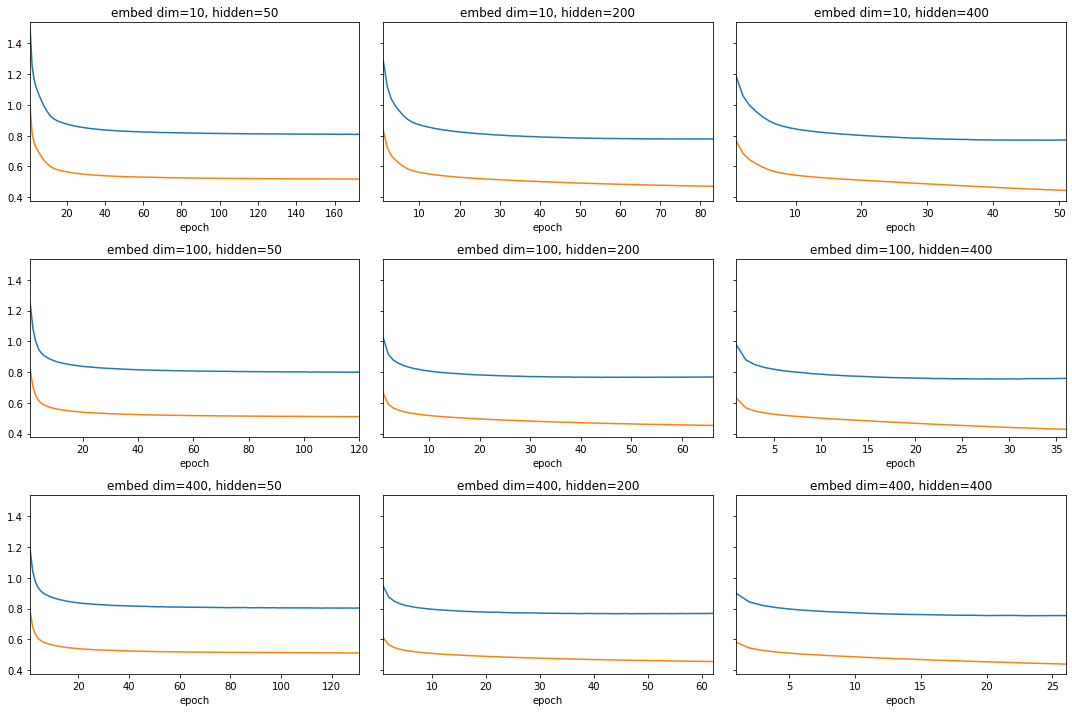

In [100]:
g = models_df.groupby(['embedding_dimension', 'rnn_hidden_dimension'])

columns = 3
rows = int(math.ceil(len(g) / columns))
fig, axs = plt.subplots(columns, rows, figsize=(15, 10), sharey=True)
for idx, ((embedding_dimension, rnn_hidden_dimension), t) in enumerate(g):
    row, column = divmod(idx, columns)
    ax = axs[row][column]
    t.set_index('epoch').dev_loss.plot(ax=ax)
    t.set_index('epoch').train_loss.plot(ax=ax)
    ax.set_title(f'embed dim={embedding_dimension}, hidden={rnn_hidden_dimension}')
    plt.tight_layout()

In [194]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, device='cuda',
    rnn_type='gru', embedding_dimension=10, rnn_hidden_dimension=50,
    batch_size=1024, max_epochs=30
)

lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=5)

Epoch 1: train loss: 0.9356ss: 0.9120	assess loss: 1.4176
	 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 HH ZH EH1 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 F ER2 M <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 <PAD> <PAD> <PAD> <PAD> <PAD> DH
Epoch 2: train loss: 0.8087ss: 0.7788	assess loss: 1.2423
	 <PAD> <PAD> <PAD> <PAD> <PAD> AH0 <PAD> <PAD> <PAD> <PAD>
	 P <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 <PAD> N <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 Z OY0 R N
	 S P N AA1 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Epoch 3: train loss: 0.7540ss: 0.7494	assess loss: 1.1631
	 F M OY1 AO2 L
	 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 K <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 <PAD> S <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Epoch 4: train loss: 0.7210ss: 0.7061	assess loss: 1.1139
	 N AH0 IH0

([0.9356099367141724,
  0.8087088465690613,
  0.7540237307548523,
  0.7209886312484741,
  0.6967448592185974,
  0.6739047765731812,
  0.6535904407501221,
  0.6362389326095581,
  0.6216400861740112,
  0.6103012561798096,
  0.6015194058418274,
  0.5949743390083313,
  0.5898377299308777,
  0.5854893326759338,
  0.5819236040115356,
  0.5788588523864746,
  0.5759522318840027,
  0.573191225528717,
  0.5707221627235413,
  0.5683090686798096,
  0.5661535859107971,
  0.5641298294067383,
  0.5620342493057251,
  0.5602555274963379,
  0.5586839318275452,
  0.5569602251052856,
  0.5553275942802429,
  0.5539683103561401,
  0.5527571439743042,
  0.5513260364532471],
 [1.4176040887832642,
  1.242305874824524,
  1.1630631685256958,
  1.1138874292373657,
  1.0776551961898804,
  1.0427870750427246,
  1.0115262269973755,
  0.9848397374153137,
  0.9625539183616638,
  0.9455310702323914,
  0.9318764805793762,
  0.9219695329666138,
  0.9138519763946533,
  0.906640887260437,
  0.9018130302429199,
  0.89640927

## Probability of Real Words ##

In [184]:
%%time

df['probability'] = df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

KeyboardInterrupt: 

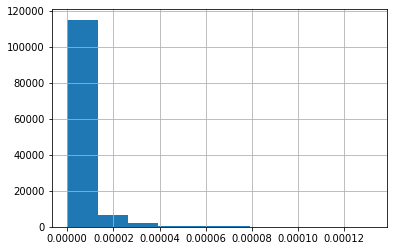

In [113]:
df.sort_values('probability', ascending=False, inplace=True)
df.probability.hist(bins=10)

In [112]:
ta = train_df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))
da = dev_df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

In [116]:
ta.mean(), da.mean()

(4.1458175522306245e-06, 2.6404366804457268e-06)

In [118]:
ta.describe()

count    9.874600e+04
mean     4.145818e-06
std      8.665914e-06
min      1.547244e-19
25%      1.044497e-07
50%      9.216081e-07
75%      4.115278e-06
max      1.317877e-04
Name: pronunciation, dtype: float64

In [119]:
da.describe()

count    2.500000e+04
mean     2.640437e-06
std      7.293921e-06
min      5.533933e-34
25%      3.195453e-09
50%      1.424988e-07
75%      1.648859e-06
max      1.317877e-04
Name: pronunciation, dtype: float64

In [105]:
df[df.length == 3]

,word,pronunciation,phoneme_ids,pronunciation_string,length,probability
121826,wieck,"[W, IY1, K]","[1, 58, 29, 14, 2]",W IY1 K,3,1.000528e-04
120544,weik,"[W, IY1, K]","[1, 58, 29, 14, 2]",W IY1 K,3,1.000528e-04
120286,weak,"[W, IY1, K]","[1, 58, 29, 14, 2]",W IY1 K,3,1.000528e-04
120496,weick,"[W, IY1, K]","[1, 58, 29, 14, 2]",W IY1 K,3,1.000528e-04
120434,week,"[W, IY1, K]","[1, 58, 29, 14, 2]",W IY1 K,3,1.000528e-04
...,...,...,...,...,...,...
57062,its,"[IH0, T, S]","[1, 32, 5, 16, 2]",IH0 T S,3,1.182546e-10
89281,pshew,"[P, SH, UW1]","[1, 8, 37, 43, 2]",P SH UW1,3,1.157643e-10
1793,aha,"[AA2, HH, AA1]","[1, 25, 40, 10, 2]",AA2 HH AA1,3,3.615145e-11
4395,aoun,"[AW2, UW1, N]","[1, 41, 43, 15, 2]",AW2 UW1 N,3,1.152768e-11


### Comparing Multiple Pronunciations ###

In [117]:
df[df.word == 'with'].sort_values('probability', ascending=False)

,word,pronunciation,phoneme_ids,pronunciation_string,length,probability
122549,with,"[W, IH1, TH]","[1, 58, 55, 18, 2]",W IH1 TH,3,1.513982e-05
122548,with,"[W, IH1, DH]","[1, 58, 55, 64, 2]",W IH1 DH,3,9.611305e-07
122550,with,"[W, IH0, TH]","[1, 58, 32, 18, 2]",W IH0 TH,3,3.394849e-07
122551,with,"[W, IH0, DH]","[1, 58, 32, 64, 2]",W IH0 DH,3,4.960389e-08


In [121]:
df[df.word == 'tomato'].sort_values('probability', ascending=False)

,word,pronunciation,phoneme_ids,pronunciation_string,length,probability
113135,tomato,"[T, AH0, M, AA1, T, OW2]","[1, 5, 3, 19, 10, 5, 30, 2]",T AH0 M AA1 T OW2,6,0.000007
113134,tomato,"[T, AH0, M, EY1, T, OW2]","[1, 5, 3, 19, 4, 5, 30, 2]",T AH0 M EY1 T OW2,6,0.000002


In [122]:
df[df.word=='pajamas'].sort_values('probability', ascending=False)

,word,pronunciation,phoneme_ids,pronunciation_string,length,probability
82276,pajamas,"[P, AH0, JH, AE1, M, AH0, Z]","[1, 8, 3, 54, 28, 19, 3, 26, 2]",P AH0 JH AE1 M AH0 Z,7,3.912744e-09
82275,pajamas,"[P, AH0, JH, AA1, M, AH0, Z]","[1, 8, 3, 54, 10, 19, 3, 26, 2]",P AH0 JH AA1 M AH0 Z,7,1.857462e-09


In [123]:
lm.calculate_probability(['P', 'R', 'IH1', 'F', 'S'])

1.4803692350550988e-06

In [124]:
lm.calculate_probability(['P', 'R', 'IH1', 'F', 'Z'])

1.5566248398144037e-08

### GENERATE PRONUNCIATIONS ###

In [186]:
for _ in range(10):
    pronunciation = lm.generate(100, temperature=None)
    pronunciation_string = ' '.join(pronunciation)
    matches = df[df.pronunciation_string == pronunciation_string]
    
    print(pronunciation_string)
    if len(matches) > 0:
        print('\t', matches.iloc[0]['word'], len(matches), 'total')
    print()

ER1 IH0 T

Y UW1 Z
	 hughs 6 total

AE1 N CH AH0 L

R IH1 N IH0 S

OW1 N AH0
	 oana 1 total

L IH1 M AH0 N
	 limon 1 total

L EH1 S S

OW1 M Z ER0

OW0 AH0 N K L EH1 M

AA1 L AH0 D



### Play with Embeddings ###

In [187]:


def most_similar_phonemes(embedding, topn=10):
    other_to_sim = {
        phoneme: cosine_similarity(embedding_for(phoneme), embedding).item()
        for phoneme in phoneme_to_idx

    }

    for other_phoneme, similarity in sorted(other_to_sim.items(), key=lambda p: -p[1])[:topn]:
        if other_phoneme != phoneme:
            print(f'[{similarity:.3f}]\t{other_phoneme}')
        
most_similar_phonemes(embedding_for('V'))

[1.000]	V
[0.830]	CH
[0.716]	K
[0.709]	L
[0.701]	UH0
[0.686]	N
[0.654]	DH
[0.631]	JH
[0.623]	OY0
[0.619]	D


In [ ]:
# embeddings = lm.embeddings
embeddings = lm.embedding.weight.cpu().detach().numpy()
normed_embeddings = normalize(embeddings)

num_clusters = 3
kmeans = KMeans(num_clusters)
kmeans.fit(normed_embeddings)

grouped = defaultdict(set)
for idx, label in enumerate(kmeans.labels_):
    phoneme = lm.vocab[idx]
    grouped[label].add(phoneme)
grouped

In [ ]:
df.set_index('word').loc['fish']

In [203]:
# For consonants
# - voicing
# - place: bilabial, dental, alveolar, palatal, velar
# - manner: stop, fricative, nasal

# For vowels
# - front/back
# - closed/open
# - rounding

# General
# - syllabic

# TODO: combine multiple vectors together, e.g. {B, G, V, DH, D} for voiced
voicing = embedding_for('B') - embedding_for('P')
forwarding = embedding_for('P') - embedding_for('K')
frication = embedding_for('F') - embedding_for('P')

new = embedding_for('TH') + voicing
# new = embedding_for('S') + voicing
# new = embedding_for('T') + frication
# new = embedding_for('K') + forwarding

phoneme_to_sim = {}
for phoneme in phoneme_to_idx:
    this_embs = embedding_for(phoneme)
    sim = cosine_similarity(new, this_embs).item()
    phoneme_to_sim[phoneme] = sim

sorted(phoneme_to_sim.items(), key=lambda p: -p[1])[:3]

[('TH', 0.8653479218482971),
 ('B', 0.830823540687561),
 ('G', 0.7448738217353821)]

In [195]:
import numpy as np
# np.mean([embedding_for('B'), embedding_for('V')], axis=0)
voiced = np.mean([embedding_for(phoneme) for phoneme in ['B', 'V', 'G', 'Z', 'ZH', 'DH', 'JH']], axis=0)
voiceless = np.mean([embedding_for(phoneme) for phoneme in ['P', 'F', 'K', 'S', 'SH', 'TH', 'CH']], axis=0)
voicing = voiced - voiceless
most_similar_phonemes(voicing + embedding_for('S'))

[0.974]	S
[0.747]	EY0
[0.623]	EY2
[0.577]	SH
[0.534]	F
[0.514]	P
[0.498]	</W>
[0.409]	TH
[0.408]	B
[0.373]	M


In [193]:
most_similar_phonemes(voicing)

[0.813]	D
[0.756]	DH
[0.715]	TH
[0.699]	T
[0.643]	ZH
[0.577]	G
[0.556]	JH
[0.535]	AO1
[0.535]	UH1
[0.502]	AW0


In [157]:
# After fixing the to(device) get rid of this
def embedding_for(phoneme):
    with torch.no_grad():
        phoneme_idx = lm.phoneme_to_idx[phoneme]
        k = torch.LongTensor([phoneme_idx]).to(lm.device)
        return lm.embedding(k).cpu().numpy()
embedding_for('P')

array([[-1.0135626 ,  0.20750469, -0.4180895 ,  1.3340969 , -0.12086653,
        -2.1960807 , -0.45291305,  0.4569592 ,  0.07522547,  0.87175137]],
      dtype=float32)

In [158]:
(embedding_for('B') - embedding_for('P')).sum()

-0.07739544

In [160]:
from phoneme_lm import START, END, PAD
def analogy(lm, a, b, c):
    """
    a - b = c - w
    argmax(w) over sim(w, c - a + b)
    """
    emb_a = embedding_for(a)
    emb_b = embedding_for(b)
    emb_c = embedding_for(c)
    
    all_phonemes = set(lm.vocab) - {START, END, PAD}
    
    phoneme_to_sim = {}
    for phoneme in all_phonemes:
        if phoneme in {a, b, c}:
            continue
        
        emb_p = embedding_for(phoneme)
        sim = cosine_similarity(emb_p, emb_c - emb_a + emb_b)
        phoneme_to_sim[phoneme] = sim.item()
    return phoneme_to_sim

analogies = analogy(lm, 'P', 'B', 'K')
for phoneme, sim in sorted(analogies.items(), key=lambda p: -p[1]):
    print(f'[{sim:.4}] {phoneme}')


[0.498] OY1
[0.4973] SH
[0.4515] M
[0.4108] D
[0.3738] AO1
[0.3342] UH0
[0.2958] OW1
[0.2806] OW0
[0.2758] AA1
[0.2662] AW2
[0.2656] EY1
[0.2346] UW0
[0.2251] IY1
[0.222] AA0
[0.2158] OY0
[0.2139] TH
[0.1858] EY0
[0.1721] R
[0.1599] Z
[0.1589] L
[0.153] AY0
[0.1449] F
[0.1372] EH2
[0.1323] EY2
[0.1253] Y
[0.103] AW1
[0.07413] HH
[0.07285] T
[0.05803] IH2
[0.05346] AH2
[0.0328] JH
[0.01272] EH1
[0.00443] ZH
[-0.01059] S
[-0.02509] AE1
[-0.02699] IH1
[-0.03576] IY0
[-0.04452] EH0
[-0.06602] AO2
[-0.08933] DH
[-0.1085] W
[-0.1097] AO0
[-0.112] IY2
[-0.1188] UH2
[-0.1345] AH0
[-0.1658] AA2
[-0.1766] OW2
[-0.1769] IH0
[-0.2032] UH1
[-0.2056] G
[-0.2099] AE0
[-0.2256] AY1
[-0.2372] AW0
[-0.2824] CH
[-0.3048] OY2
[-0.3246] V
[-0.3426] UW1
[-0.4259] AE2
[-0.4414] UW
[-0.4853] NG
[-0.508] UW2
[-0.5275] ER0
[-0.529] ER2
[-0.5458] ER1
[-0.5772] AH1
[-0.6448] AY2
[-0.6906] N
